In [100]:
import json
import numpy as np

import re
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import VotingClassifier

from collections import Counter

from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier

from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

from sklearn import metrics

In [101]:
file = '../data_resources/topics/kamerstukken/kamerstukken_topics_first.json'
data_first = json.load(open(file))

file = '../data_resources/topics/kamerstukken/kamerstukken_topics_second.json'
data_second = json.load(open(file))

corpus = []
y = []


for obj in data_first:
    if not obj['category'] == 'NOCAT' and not obj['content'] == 'NOCONTENT':
        corpus.append(obj['content'])
        y.append(obj['category'])
        
for obj in data_second:
    if not obj['category'] == 'NOCAT' and not obj['content'] == 'NOCONTENT':
        corpus.append(obj['content'])
        y.append(obj['category'])

print(len(corpus))
print(len(y))

28286
28286


In [126]:
import unicodedata


def slugify(name):
    name = name.lower()
    name = name.replace(" ", "-")
    name = name.replace("'", "")
    normal = unicodedata.normalize('NFKD', name).encode('ASCII', 'ignore')
    return normal

# for obj in topics:
#     [main, sub] = obj.split(" | ")
    
#     main_slug = slugify(main)
    
#     main_topic_object = {'name' : main, 'slug' : main_slug, 'sub' : []}
    
#     for obj2 in topics:
#         [main2, sub2] = obj2.split(" | ")
        
#         if main2 == main:
#             main_topic_object['sub'].append({'name' : sub2, 'slug' : slugify(sub2)})
            
#     if main_topic_object not in topics_json_result:
#         topics_json_result.append(main_topic_object)
    
    
# for main in topics_json_result:
#     print(main['slug'])
#     print(main['name'])
    
#     for sub in main['sub']:
#         print('-- {}'.format(sub['slug']))
topics_json = []

for obj in topics:
    if not obj in topics_json:
        topics_json.append(obj)

# print(topics_json)
with open('../data_resources/topics/kamerstukken/kamerstukken_topics_simple.json', 'w') as outfile:
    json.dump({'topics' : topics_json}, outfile)
    

In [118]:
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.porter import PorterStemmer

# st = SnowballStemmer(language='dutch')
st = PorterStemmer()

def pre_process(document):
    document = document.lower()
    words = document.split(' ')
    new_words = []
    for word in words:
        if not '_' in word:
            new_words.append(st.stem(word))

    document = " ".join(new_words)
    
    pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    document = pattern.sub('', document)
    return re.sub('[0-9]+', '', document)

transformer = TfidfVectorizer(smooth_idf=True, min_df=0.00000001, max_df=0.2, sublinear_tf=True)

In [119]:
a = 'Zilveren Kruis Achmea dat Arkin \u00abzelf verantwoordelijkheid moet nemen\u00bb? Wat bedoelt zij daarmee? 3 Vraag 7 Hoe kan een zorginstelling nog voldoen aan een zorgplicht als zij niet zeker is dat de zorgverzekeraar ook daadwerkelijk de gemaakte afspraken voor vergoeding nakomt? Erkent u dat op deze wijze zorgverzekeraars op ontoelaatbare wijze zorgvergoeding tot bedrijfsrisico maken van zorginstellingen? Kunt u uw antwoord toelichten? Vraag 8 Kunt u uitleggen hoe het mogelijk is dat er afdoende budget is voor de geestelijke gezondheidszorg (GGZ), maar dat zorgverzekeraars dit budget zo verdelen dat er wachtlijsten zijn en budget over? Vindt u ook dat wederom blijkt dat de verdeling van het budget niet aan zorgverzekeraars kan worden overgelaten? Wat gaat u doen om dit op te lossen? Kunt u dit toelichten? 4 Vraag 9 Kunt u uitleggen wat er maatschappelijk is aan het gesol Zilveren Kruis Achmea met de zwakste ggz-pati\u00ebnten, waarbij een goede ondersteuning van cruciaal belang is voor het welzijn van de pati\u00ebnt en het beperken van (maatschappelijke) overlast door de pati\u00ebnt? Vraag 10 Erkent u dat er een groot risico is op onderbehandeling van pati\u00ebnten met ernstige psychische aandoeningen in Amsterdam en andere grote steden, als Zilveren Kruis Achmea blijft weigeren de kosten te vergoeden? Realiseert u zich dat onderbehandeling leidt tot terugkerende crises en daarmee het herstel van een pati\u00ebnt belemmert en leidt tot onnodig leed en een langer durend ziekteproces'
b = pre_process(a)

print(a)
print(b)

Zilveren Kruis Achmea dat Arkin «zelf verantwoordelijkheid moet nemen»? Wat bedoelt zij daarmee? 3 Vraag 7 Hoe kan een zorginstelling nog voldoen aan een zorgplicht als zij niet zeker is dat de zorgverzekeraar ook daadwerkelijk de gemaakte afspraken voor vergoeding nakomt? Erkent u dat op deze wijze zorgverzekeraars op ontoelaatbare wijze zorgvergoeding tot bedrijfsrisico maken van zorginstellingen? Kunt u uw antwoord toelichten? Vraag 8 Kunt u uitleggen hoe het mogelijk is dat er afdoende budget is voor de geestelijke gezondheidszorg (GGZ), maar dat zorgverzekeraars dit budget zo verdelen dat er wachtlijsten zijn en budget over? Vindt u ook dat wederom blijkt dat de verdeling van het budget niet aan zorgverzekeraars kan worden overgelaten? Wat gaat u doen om dit op te lossen? Kunt u dit toelichten? 4 Vraag 9 Kunt u uitleggen wat er maatschappelijk is aan het gesol Zilveren Kruis Achmea met de zwakste ggz-patiënten, waarbij een goede ondersteuning van cruciaal belang is voor het welzij

In [120]:
X_train_corpus, X_test_corpus, y_train, y_test = train_test_split(corpus, y, test_size=0.2, random_state=42)

X_train = transformer.fit_transform(X_train_corpus)
X_test = transformer.transform(X_test_corpus)

print(np.shape(X_train))
print(np.shape(y_test))

(22628, 148923)
(5658,)


In [121]:
clf = SGDClassifier(loss='log', penalty='l1', alpha=1e-6, random_state=42, max_iter=10, tol=None)
%time clf = OneVsRestClassifier(clf).fit(X_train, y_train)

%time y_pred = clf.predict(X_test)

proba = clf.predict_proba(X_test[0])
print(len(proba[0]))

score = accuracy_score(y_test, y_pred)

print(score)

CPU times: user 49.9 s, sys: 16 ms, total: 49.9 s
Wall time: 49.9 s
CPU times: user 308 ms, sys: 1 µs, total: 308 ms
Wall time: 307 ms
111
0.7790738776952987


In [122]:
transformer.get_feature_names()

['00',
 '000',
 '0000',
 '00000000',
 '0000000000000129',
 '00000001',
 '00000023',
 '0000003271',
 '0000005146_nvog',
 '0000010',
 '0000022327',
 '0000061038',
 '0000076375',
 '0000087154',
 '0000088953',
 '00000aab0f01',
 '00000aab0f02',
 '0000104093',
 '0000122079',
 '0000122970',
 '0000143162',
 '0000165855',
 '0000204162',
 '0000206536',
 '0000231673',
 '0000496172',
 '0000591773',
 '00008go001',
 '0001',
 '000109',
 '000126',
 '0002',
 '0003',
 '000345',
 '0004',
 '0005',
 '000622',
 '000__',
 '000_euro__',
 '000_zorgzzp',
 '000km',
 '000kwh',
 '000m3',
 '001',
 '0010',
 '0011',
 '0012',
 '00120',
 '00144feab7de',
 '00144feabdc0',
 '0016',
 '0017',
 '00191b53ff',
 '001_894_1465482622965',
 '002',
 '0021',
 '0022',
 '002227',
 '0023',
 '002331',
 '00240',
 '0025',
 '0026',
 '002662',
 '00269',
 '003',
 '00308',
 '0031',
 '00311',
 '00355',
 '00397',
 '004',
 '0043',
 '004374',
 '004651',
 '004657',
 '0048',
 '005',
 '00540',
 '0059',
 '006',
 '00607',
 '0062',
 '0067',
 '007',
 '0

In [140]:
pickle.dump( clf, open("../app/modules/enrichment/topics/models/classifier_kamerstukken.sav", 'wb') )
pickle.dump( transformer, open("../app/modules/enrichment/topics/models/transformer_kamerstukken.sav", 'wb') )

In [63]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 10)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

<module 'matplotlib.pyplot' from '/home/rothweiler/.local/lib/python3.6/site-packages/matplotlib/pyplot.py'>

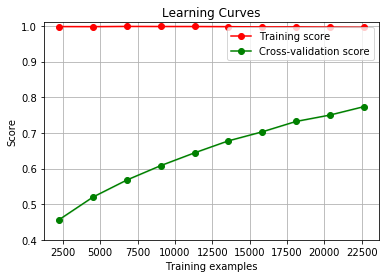

In [64]:
title = "Learning Curves"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=1, test_size=0.2, random_state=0)

X = transformer.fit_transform(corpus)
plot_learning_curve(clf, title, X, y, ylim=(0.4, 1.01), cv=cv, n_jobs=1)